# Imports

In [1]:
import faiss
import numpy as np
from collections import defaultdict
import pandas as pd
import config


from src.helper import create_embeddings, create_index, semantic_similarity, call_llm

/Users/pallavimugale/Documents/@GenAI_Python/Customer_Support_Agent/Customer_Support_Agent/customer_support_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset

In [2]:
# csv into datafreame
df= pd.read_csv(config.CUSTOMER_SUPPORT_TRAINNING_DATASET)

#preview the first top 5 data
df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


<Axes: xlabel='category'>

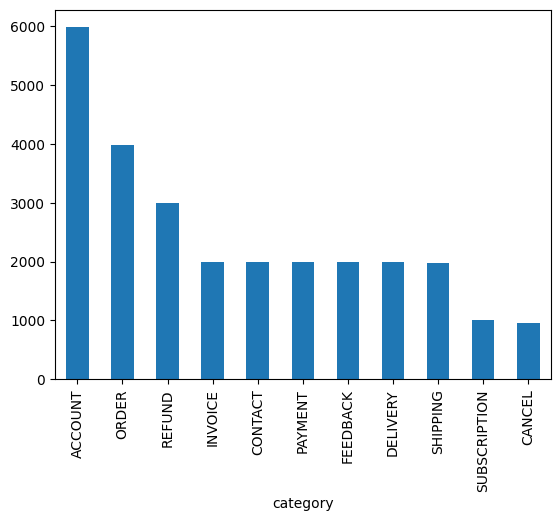

In [3]:
#count the categories and plot the bar chart graph where x :show the category and y will show the count 
df['category'].value_counts().plot(kind='bar')

In [4]:
# create a dict where key is category and value will be list of unique 'intent' column values
category_intent_dict=defaultdict(set) #used set for unique items

#loop earch row and pair the category and intent
for category ,intent in zip(df['category'],df['intent']):
    category_intent_dict[category].add(intent)

#convert defaultdict to regular dict and sets the lists for display
category_intent_dict={k:list(v) for k,v in category_intent_dict.items()}

category_intent_dict


{'ORDER': ['change_order', 'place_order', 'track_order', 'cancel_order'],
 'SHIPPING': ['set_up_shipping_address', 'change_shipping_address'],
 'CANCEL': ['check_cancellation_fee'],
 'INVOICE': ['check_invoice', 'get_invoice'],
 'PAYMENT': ['check_payment_methods', 'payment_issue'],
 'REFUND': ['check_refund_policy', 'track_refund', 'get_refund'],
 'FEEDBACK': ['review', 'complaint'],
 'CONTACT': ['contact_customer_service', 'contact_human_agent'],
 'ACCOUNT': ['create_account',
  'registration_problems',
  'delete_account',
  'switch_account',
  'recover_password',
  'edit_account'],
 'DELIVERY': ['delivery_period', 'delivery_options'],
 'SUBSCRIPTION': ['newsletter_subscription']}

In [5]:
#calculate the. avg token count for instruction and responses using split method
avg_instruction_token_count = df['instruction'].apply(lambda x:len(x.split())).mean()
avg_response_token_count = df['response'].apply(lambda x:len(x.split())).mean()

print(f'Avg of instrauction token count: {avg_instruction_token_count}')
print(f'Avg rsponse token count: {avg_response_token_count}')

Avg of instrauction token count: 8.690979458172075
Avg rsponse token count: 104.78903691574874


# Vectorization of dataset

In [ ]:
vectors = create_embeddings(df, column_name='instruction', model=config.EMBEDDING_MODEL) 

In [ ]:
vectors.shape

(26872, 384)

In [ ]:
#save the embedding to vector db 
index= create_index(vectors,index_file_path=config.VECTOR_INDEX_FILE_PATH)

faiss index is created and added to the file


# Load Vector DB

In [ ]:
index= faiss.read_index(config.VECTOR_INDEX_FILE_PATH)

# User Query

In [ ]:
query="change my address"

In [ ]:
distances, indices= semantic_similarity(query, index, config.EMBEDDING_MODEL)

top_similar_instructions=df.iloc[indices[0]].reset_index(drop=True)
top_similar_instructions['distance']=distances[0]

In [ ]:
responses=top_similar_instructions['response'].to_list()
#print('---#################----')
#print("Responses from the dataset:\n", top_similar_instructions[['instruction', 'intent', 'response']].to_markdown(index=False))
#print('---#################----')
print("Response from LLM:\n", call_llm(query, responses))

Response from LLM:
 Based on the input query "change my address", I would:

1. Determine the urgency of the query as 3 (out of 5), as it's a relatively straightforward request that doesn't require immediate attention.

2. Categorize the input query as "Operations" (specifically, account management).

3. Generate a humble response:
"Definitely! I'm here to assist you with changing your address. To get started, please provide me with your current shipping address and the new address you would like to update it to."

Note: If the customer's query is unclear or requires further clarification, I would ask a follow-up question, such as "Could you please provide more details about the address you'd like to change, such as your current shipping address and the new address you'd like to update it to?"
